## Hello there! My capstone project has to do with the field of Natural Language Programming (NLP) known as topic modeling (TM). ##

It involves extracting the key words that summarize _what_ exactly a document is about, especially within the context of a larger corpus of documents.

To this end, I am using the `gensim` library which specializes in efficient implementations of TM algorithms. Specifically, I will be using Latent Dirichlet Allocation (LDA), a popular model that generates _t_ discriminative topics based on assumptions about the number of topics and their distributions throughout the corpus.

The corpus I am working with is from the `stat.ML` category of the [arXiv](https://arxiv.org/list/stat.ML/recent) database. I have about 18,000 paper abstracts covering a range of Machine Learning topics such as Optimization, Neural Network Architecture, and Applications to medical data.

### Problem : ### 
**Within the context of an overarching topic, how can we extract more detailed subtopics and provide similar documents/recommendations effectively? (Secondary Problem) Can we use Dynamic Topic Modeling to show the papers that have been most influential in their fields?**

### Data: ###
**I used the same data I collected from Milestone #2 (with function arx_and_recreation()). I isolate just the abstracts (no date for now) in a Pandas Series or list**

### Pre-Processing : ###

I use a combination of 
    - regular expressions : strip extraneous punctuation/formatting/etc. 
    - English stop words : strip useless connecting words
    - lemmatizers : combine variations of words (tense, pluaral) into one
    - phrasers : common words that go together (like bigrams) are combined into one. 

In [32]:
#imports
import re
import json
import gensim.parsing.preprocessing as genpre
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import gensim
import pickle
import pandas as pd
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Text pre-processor:

lmtzr= WordNetLemmatizer()
def prep_text(text):
     #this regex removes LATEX formatting, numbers, citations, splits hyphens into two words
    myreg=r'\\[\w]+[\{| ]|\$[^\$]+\$|\(.+\, *\d{2,4}\w*\)|\S*\/\/\S*|[\\.,\/#!$%\^&\*;:{}=_`\'\"~()><\|]|\[.+\]|\d+|\b\w{1,2}\b'
    parsed_data = text.replace('-', ' ')
    parsed_data = re.sub(myreg, '', parsed_data)
    parsed_data = [lmtzr.lemmatize(w) for w in parsed_data.lower().split() if w not in genpre.STOPWORDS]
    if len(parsed_data) ==1: return parsed_data[0]
    return parsed_data

Having transformed all my abstracts from things that looked like this:
```
In this article, we derive concentration inequalities for the cross-validation estimate of the generalization error for empirical risk minimizers. In the general setting, we prove sanity-check bounds in the spirit of \cite{KR99} \textquotedblleft\textit{bounds showing that the worst-case error of this estimate is not much worse that of training error estimate} \textquotedblright . General loss functions and class of predictors with finite VC-dimension are considered. We closely follow the formalism introduced by \cite{DUD03} to cover a large variety of cross-validation procedures including leave-one-out cross-validation, $k$% -fold cross-validation, hold-out cross-validation (or split sample), and the leave-$\upsilon$-out cross-validation.   In particular, we focus on proving the consistency of the various cross-validation procedures. We point out the interest of each cross-validation procedure in terms of rate of convergence. An estimation curve with transition phases depending on the cross-validation procedure and not only on the percentage of observations in the test sample gives a simple rule on how to choose the cross-validation. An interesting consequence is that the size of the test sample is not required to grow to infinity for the consistency of the cross-validation procedure.
```
to this (it is not perfect but the odd strings that get thru the cracks are too rare to be of any effect):
```
['article', 'derive', 'concentration', 'inequality', 'cross', 'validation', 'estimate', 'generalization', 'error', 'empirical', 'risk', 'minimizers', 'general', 'setting', 'prove', 'sanity', 'check', 'bound', 'spirit', 'kr', 'textquotedblleftbounds', 'showing', 'worst', 'case', 'error', 'estimate', 'worse', 'training', 'error', 'estimate', 'general', 'loss', 'function', 'class', 'predictor', 'finite', 'dimension', 'considered', 'closely', 'follow', 'formalism', 'introduced', 'dud', 'cover', 'large', 'variety', 'cross', 'validation', 'procedure', 'including', 'leave', 'cross', 'validation', 'fold', 'cross', 'validation', 'hold', 'cross', 'validation', 'split', 'sample', 'leave', 'cross', 'validation', 'particular', 'focus', 'proving', 'consistency', 'cross', 'validation', 'procedure', 'point', 'cross', 'validation', 'procedure', 'term', 'rate', 'convergence', 'estimation', 'curve', 'transition', 'phase', 'depending', 'cross', 'validation', 'procedure', 'percentage', 'observation', 'test', 'sample', 'give', 'simple', 'rule', 'choose', 'cross', 'validation', 'interesting', 'consequence', 'size', 'test', 'sample', 'required', 'grow', 'infinity', 'consistency', 'cross', 'validation', 'procedure']
```

I am now in good position to conduct a topic analysis of my pre-processed text. I would like to do some Exploratory Data Analysis, too, to see what the distribution of my words are, etc. But first, let's examine the key gensim object with which we will be working:

    - Corpus: this is the list of list of tokens/n_grams (a list such as above for every abstract)
    - Dictionary: this assigns every unique token an id. It is used to look up id->token and token->id
    - Bag Of Words (BoW): sums the total occurances of a token in a document (word ordering is not considered)
    - LdaModel: uses the dictionary and BOW to generate a probablity distribution of topics across docs, and of words across topics
    - Market Matrix: a more efficient way of storing th corpus, useful when calculating similarities between documents. 



In [19]:
# load up the relevant objects

# The raw documents: 
abstracts = pd.read_csv('./new_hope_data/arxiv_csML.csv')['summary']

with open('./the_data_strikes_back/bigrams', 'rb') as fp:
    corpus = pickle.load(fp)

dictionary = corpora.Dictionary(corpus)
bow = [dictionary.doc2bow(text) for text in corpus]

# The gensim phraser I'm using
bigrams = gensim.utils.SaveLoad.load('./the_data_strikes_back/bigram_phrases')
#define the lda model
model = LdaModel(bow, id2word=dictionary, num_topics=5)

# Matrix representation of my corpus
# corpora.MmCorpus.serialize('./the_data_strikes_back/full_bigram_corpus.mm', corpus)
corp_matrix = corpora.MmCorpus('./the_data_strikes_back/full_bigram_corpus.mm')


In [17]:
# import copy
# q = copy.deepcopy(dictionary)

1088

**I'm going to fit a model and visualize it now to make a point, later on I'll explain it in more detail**

In [26]:
# Let's naively fit a model to this corpus, and see what happens
full_lda = LdaModel(corpus=bow, num_topics=6, id2word=dictionary, alpha= 'auto', eta=.09)
full_lda.show_topics()

[(0,
  '0.012*"data" + 0.012*"method" + 0.009*"feature" + 0.008*"based" + 0.007*"proposed" + 0.007*"approach" + 0.006*"classification" + 0.005*"result" + 0.005*"algorithm" + 0.005*"signal"'),
 (1,
  '0.015*"data" + 0.011*"method" + 0.010*"algorithm" + 0.007*"machine_learning" + 0.006*"based" + 0.006*"learning" + 0.006*"performance" + 0.006*"approach" + 0.006*"prediction" + 0.006*"model"'),
 (2,
  '0.030*"method" + 0.019*"graph" + 0.018*"problem" + 0.017*"algorithm" + 0.008*"data" + 0.008*"based" + 0.008*"proposed" + 0.007*"approach" + 0.007*"optimization" + 0.006*"function"'),
 (3,
  '0.018*"algorithm" + 0.013*"learning" + 0.013*"problem" + 0.009*"policy" + 0.009*"model" + 0.008*"agent" + 0.007*"based" + 0.006*"approach" + 0.006*"reinforcement_learning" + 0.006*"task"'),
 (4,
  '0.038*"model" + 0.021*"network" + 0.011*"method" + 0.010*"data" + 0.009*"learning" + 0.008*"approach" + 0.008*"training" + 0.008*"task" + 0.007*"based" + 0.006*"representation"'),
 (5,
  '0.017*"model" + 0.014*

As you can see, there is very high overlap between topics with a few generic ML terms taking the top spots. While there are discriminating terms "beneath" the most highly prevalent terms (you can see them by lowering $\lambda$ on the slider below), I am inclined to filter out these common terms altogether. _Especially_ because as of now our corpus is only ML, so "method", "model", etc. won't help us. If we had different categories of articles, leaving these terms may be useful. 

In [27]:
# If you set the lambda value to be lower, you can see more exclusive terms
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(full_lda, bow, dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.043200  0.052050       1        1  13.913700
1      0.106708 -0.089868       2        1  14.708337
2     -0.104124  0.002116       3        1  18.489582
3     -0.037187 -0.083941       4        1  11.907636
4      0.091862  0.085582       5        1  23.139009
5     -0.100459  0.034061       6        1  17.841734, topic_info=     Category          Freq                    Term         Total  loglift  \
term                                                                         
346   Default   5543.000000                   graph   5543.000000  30.0000   
439   Default   9507.000000                 network   9507.000000  29.0000   
82    Default  22239.000000                   model  22239.000000  28.0000   
101   Default  11081.000000                 problem  11081.000000  27.0000   
0     Default  14962.000000               algorithm  14962.000000  26.0000   
1951  Default   1781.000000                  policy   1781.000000  25.0000   
193   Default  19338.000000                  method  19338.000000  24.0000   
1358  Default   1466.000000                   agent   1466.000000  23.0000   
230   Default   5656.000000                function   5656.000000  22.0000   
342   Default   4629.000000            distribution   4629.000000  21.0000   
544   Default   9530.000000                learning   9530.000000  20.0000   
3227  Default   1159.000000  reinforcement_learning   1159.000000  19.0000   
7346  Default   2359.000000           deep_learning   2359.000000  18.0000   
2121  Default   3420.000000          neural_network   3420.000000  17.0000   
135   Default   2131.000000              classifier   2131.000000  16.0000   
88    Default   2791.000000            optimization   2791.000000  15.0000   
118   Default   5865.000000                    task   5865.000000  14.0000   
63    Default   4902.000000                 feature   4902.000000  13.0000   
353   Default   2500.000000                  matrix   2500.000000  12.0000   
983   Default   1883.000000                    deep   1883.000000  11.0000   
1152  Default   2876.000000                   image   2876.000000  10.0000   
5097  Default   1504.000000                   layer   1504.000000   9.0000   
810   Default   3710.000000        machine_learning   3710.000000   8.0000   
690   Default   1912.000000                   bound   1912.000000   7.0000   
3919  Default    863.000000                  reward    863.000000   6.0000   
3243  Default   1563.000000                    user   1563.000000   5.0000   
1335  Default   1415.000000                  signal   1415.000000   4.0000   
763   Default   1178.000000             environment   1178.000000   3.0000   
644   Default   5817.000000                training   5817.000000   2.0000   
217   Default  15976.000000                    data  15976.000000   1.0000   
...       ...           ...                     ...           ...      ...   
864    Topic6    358.056854             monte_carlo    527.775024   1.3357   
539    Topic6   1119.350830                   error   2254.961182   1.0232   
16     Topic6   1158.278076                estimate   2403.368652   0.9937   
618    Topic6   1164.011230                   point   2522.775391   0.9501   
180    Topic6    837.913574        high_dimensional   1671.668213   1.0330   
623    Topic6   1607.615112                  sample   4143.549805   0.7768   
249    Topic6    916.798950              regression   1977.349609   0.9550   
85     Topic6   1390.812744                  number   3562.100830   0.7832   
243    Topic6    813.528381                   noise   1730.809082   0.9687   
1470   Topic6    569.717896                 unknown   1048.935059   1.1132   
217    Topic6   3695.272705                    data  15976.334961   0.2596   
82     Topic6   4406.603027                   model  22239.619141   0.1049   
818    Topic6  

With this in mind, let us...
## Filter the most and least common terms in our corpus, to get a more discriminative model: ##

In [28]:
import numpy as np
# let's look at the most common words throughout the corpus
tot_counts = np.zeros(len(dictionary))

# goes through the (id, count) tuples in every document and increments a total count
for doc in bow:
    for w in doc:
        tot_counts[w[0]] += w[1]

masterlist = [(dictionary[i], tot_counts[i]) for i in range(len(dictionary))]

# the most common
reference = sorted(masterlist, key=lambda w: w[1], reverse=True)

In [29]:
reference[:15]
# we can see in just these top 15 there is a steep fall-off in descending term frequency

[('model', 23446.0),
 ('method', 18755.0),
 ('algorithm', 17368.0),
 ('data', 16627.0),
 ('problem', 11707.0),
 ('based', 10494.0),
 ('approach', 10204.0),
 ('learning', 10175.0),
 ('network', 9262.0),
 ('result', 6774.0),
 ('proposed', 6144.0),
 ('performance', 5449.0),
 ('function', 5355.0),
 ('task', 5323.0),
 ('feature', 5292.0)]

In [30]:
len([ref for ref in reference if ref[1] <=10])
# In contrast, there are around 25K words that occur 10 times or less

25533

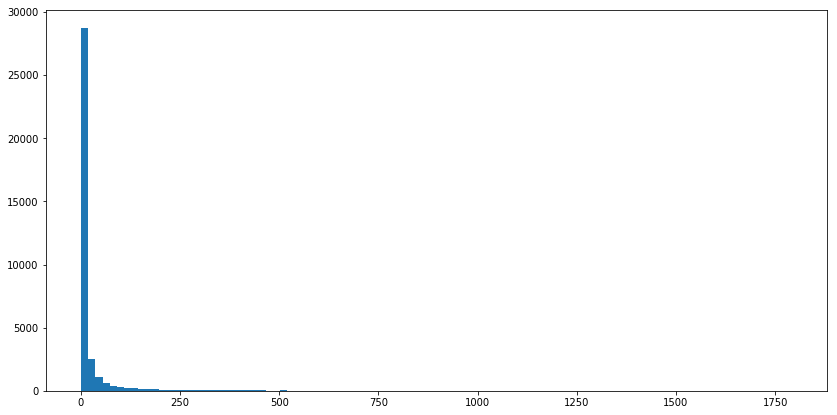

In [31]:
max_ammt = (18/10)*1000 # set this to 25000 to see the whole thing
prevalent_counts = [ref[1] for ref in reference if ref[1] <= max_ammt] 
plt.figure(figsize=(14, 7))
plt.hist(prevalent_counts, bins=100);
# plt.xlim(0, 5000);

**By visually inspecting this historgram of word terms, we can see that it is probably a good idea to filter the extreme terms. Words like "model, algorithm" on the high end, or "solomonoff" and "bssd" (which only appear twice) do not contribute to our understanding of a topic. We should instead use the central mass of our distribution as our words. Luckily, gensim makes it easy to do this**

In [34]:
# I want to figure out approx. how many words occur more than max_total of the time ( assuming it is a common ML term and not something special)
max_total = (1/6) # the maximum document frequency I'd like -I'm going to set it roughly equal to 1/num_topics so I can get better overlap
ref_cutoff = len([ref for ref in reference if ref[1] > len(corpus)*max_total])

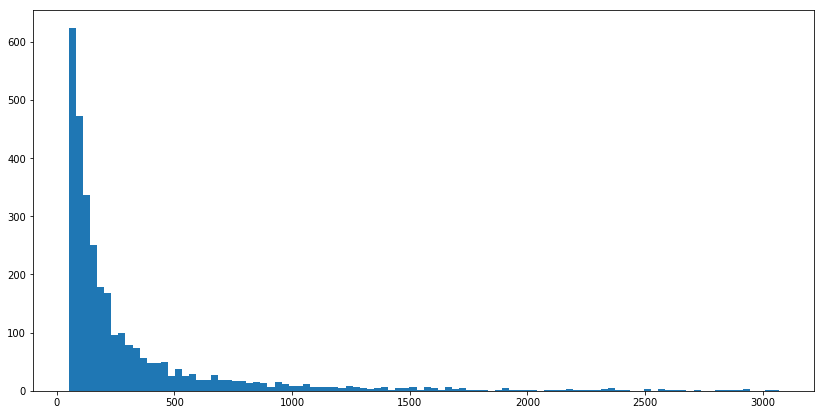

In [36]:
filtered_dictionary = copy.deepcopy(dictionary)
filtered_dictionary.filter_extremes(no_below=50) # remove terms that occur <50 times
high_tokens = [filtered_dictionary.token2id[reference[i][0]] for i in range(ref_cutoff)] # ids of tokens that'll be excised
filtered_dictionary.filter_tokens(bad_ids=high_tokens) # our 97 most common term ids, approximating words that occur more than once/10 documents
filtered_corp = [[w for w in doc if w in filtered_dictionary.token2id] for doc in corpus]
filtered_bow = [filtered_dictionary.doc2bow(doc) for doc in filtered_corp]

# now let's check our distributions again
# let's look at the most common words throughout the corpus
new_tot_counts = np.zeros(len(filtered_dictionary))

# goes through the (id, count) tuples in every document and increments a total count
for doc in filtered_bow:
    for w in doc:
        new_tot_counts[w[0]] += w[1]

new_masterlist = [(filtered_dictionary[i], new_tot_counts[i]) for i in range(len(filtered_dictionary))]

# the most common
new_reference = sorted(new_masterlist, key=lambda w: w[1], reverse=True)

new_prevalent_counts = [ref[1] for ref in new_reference]
plt.figure(figsize=(14, 7))
plt.hist(new_prevalent_counts, bins=100);
# plt.xlim(0, 5000);

In [37]:
filtered_lda = LdaModel(corpus=filtered_bow, num_topics=6, id2word=filtered_dictionary, alpha= 'asymmetric', eta=.01)
filtered_lda.show_topics()

[(0,
  '0.008*"gradient" + 0.007*"optimization" + 0.006*"sparse" + 0.006*"solution" + 0.005*"linear" + 0.005*"convergence" + 0.005*"rate" + 0.004*"point" + 0.004*"stochastic" + 0.004*"signal"'),
 (1,
  '0.009*"deep_neural" + 0.008*"neural_network" + 0.007*"inference" + 0.006*"state_art" + 0.005*"datasets" + 0.005*"accuracy" + 0.005*"complex" + 0.005*"kernel" + 0.005*"representation" + 0.004*"existing"'),
 (2,
  '0.011*"policy" + 0.007*"attack" + 0.007*"error" + 0.007*"system" + 0.007*"reinforcement_learning" + 0.006*"setting" + 0.006*"deep_learning" + 0.005*"provide" + 0.005*"test" + 0.005*"behavior"'),
 (3,
  '0.009*"user" + 0.009*"classifier" + 0.007*"dataset" + 0.006*"image" + 0.006*"datasets" + 0.006*"multiple" + 0.005*"label" + 0.005*"accuracy" + 0.004*"representation" + 0.004*"group"'),
 (4,
  '0.011*"node" + 0.010*"representation" + 0.010*"neural_network" + 0.009*"space" + 0.009*"layer" + 0.009*"architecture" + 0.008*"input" + 0.008*"kernel" + 0.007*"deep" + 0.005*"image"'),
 (5

**My rationale for the `alpha` and `eta` parameters are as follows:**

$\alpha$ is a LDA parameter that relates to how evenly distributed topics are across documents. By default, the model assumes a document is approximately equally likely to have any topic. However, this is not the case here because all my documents relate to Machine Learning. So there are generic ML terms (and topics) that may be shared across more documents than others. Thus I set `alpha = 'asymmetric'`

$\eta$ in gensim is analogous to the parameter $\beta$ in the formal LDA model. It signifies how many topics share a word. Low `eta` means that the model favors term exclusivity among topics. Again, because my corpus is so overlapping in nature, I want to set `eta` to be low

Next up...

## Visualizing the topics using pyLDAvis ##

While some people (*ahem* Dave Yarrington *ahem*) question its statistcal rigor, the pyLDAvis library is a very popular way of getting a high-level intuition on the layout of your topics model. Of primary concern to me is the horizontal bar graph on the right, which shows a list of tokens in a given topic along with their relative frequencies in the corpus. 

By visually inspecting the tokens, you can see several topics emerge: 
    - Reinforcement Learning - _policy, reinforcement_learning, agent_
    - Gradient Descent - _gradient, convergence, optimization, convex_
    - Neural Networks (may combine or split up CNN, RNN, VAE, GAN into two) - _deep_neural, rnn, cnn, convolution, variational_
    - Medical Applications of ML or "real life" datasets - _patient, user, recommendation, disease, drug_
    - Baysian/ Probablistic Methods and Estimators - _bayesian, latent_variable/space, monte_carlo, estimation_

Depending on whether you ran the cell or not, you may get significantly different-looking topic distribution. This is because LDA begins with a random seed every time it runs 

Of particular note is the relevance metric slider. When $\lambda$ is turned low (around `0.1 - 0.2`), more discriminative words become ranked higher, even though they are not the most common. **Thus, I plan to manually inspect my topics to create a human-understandable label**

In [38]:
# If you set the lambda value to be lower, you can see more exclusive terms
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(filtered_lda, filtered_bow, filtered_dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.090056  0.026201       1        1  27.727028
1      0.010475 -0.041889       2        1  17.877914
2     -0.051804  0.043627       3        1  13.997724
3      0.090635 -0.078860       4        1  16.982306
4     -0.045493 -0.059318       5        1  11.688646
5      0.086244  0.110238       6        1  11.726382, topic_info=     Category         Freq                    Term        Total  loglift  \
term                                                                       
1256  Default  1787.000000                  policy  1787.000000  30.0000   
919   Default  1871.000000                   agent  1871.000000  29.0000   
2777  Default  1899.000000             deep_neural  1899.000000  28.0000   
1259  Default  1977.000000                   state  1977.000000  27.0000   
807   Default  1560.000000                    node  1560.000000  26.0000   
1838  Default  1771.000000                    user  1771.000000  25.0000   
125   Default  1841.000000                  kernel  1841.000000  24.0000   
1349  Default  3650.000000          neural_network  3650.000000  23.0000   
2392  Default  1040.000000                  attack  1040.000000  22.0000   
1942  Default  1954.000000            architecture  1954.000000  21.0000   
90    Default  2226.000000              classifier  2226.000000  20.0000   
2422  Default  1728.000000                   layer  1728.000000  19.0000   
55    Default  1235.000000                  object  1235.000000  18.0000   
525   Default  1571.000000                bayesian  1571.000000  17.0000   
317   Default  3312.000000          representation  3312.000000  16.0000   
460   Default  3046.000000                 process  3046.000000  15.0000   
791   Default  3388.000000                   image  3388.000000  14.0000   
308   Default  2402.000000               inference  2402.000000  13.0000   
1832  Default  1199.000000  reinforcement_learning  1199.000000  12.0000   
25    Default  2731.000000                   space  2731.000000  11.0000   
540   Default  1692.000000                   prior  1692.000000  10.0000   
1605  Default   621.000000                 student   621.000000   9.0000   
385   Default  1956.000000                   error  1956.000000   8.0000   
531   Default  1384.000000             environment  1384.000000   7.0000   
684   Default  2102.000000                    deep  2102.000000   6.0000   
2025  Default  2685.000000                gradient  2685.000000   5.0000   
1900  Default   904.000000             adversarial   904.000000   4.0000   
1193  Default   734.000000                 patient   734.000000   3.0000   
196   Default  1817.000000                variable  1817.000000   2.0000   
75    Default  1776.000000                  system  1776.000000   1.0000   
...       ...          ...                     ...          ...      ...   
1259   Topic6  1310.750732                   state  1977.715576   1.7320   
525    Topic6  1036.711792                bayesian  1571.528076   1.7273   
919    Topic6  1191.312866                   agent  1871.098633   1.6919   
2527   Topic6   340.313141            latent_space   498.164185   1.7623   
309    Topic6   568.265137                  latent   953.002136   1.6263   
601    Topic6   310.959778             monte_carlo   483.186157   1.7026   
2018   Topic6   295.904449                       d   456.838989   1.7090   
1741   Topic6   463.816467        generative_model   803.031738   1.5944   
540    Topic6   847.566467                   prior  1692.059326   1.4520   
2271   Topic6   410.500031                 spatial   706.936035   1.5998   
460    Topic6  1264.366089                 process  3046.409668   1.2639   
853    Topic6   321.296417               posterior   557.787170   1.5917   
196    Topic6   687.860657                variable  1817.127686   1.1719   
1149   Topic6   552.102295   

**At this point, the bulk of the topic modeling is completed. I have chosen my number of topics, and have gotten a general human-readable tag for each topic. What's next? Well, there are several options:**

1. Set up a small program that allows one to compare a new document against the existing models and corpus. 
2. Set up Dynamic Topic Modeling to track the Evolution of a Topic over time
3. Set up a Grid-Search process for fine-tuning the number of topics and other parameters
4. Include more abstracts, this time from different fields than ML, to see how well the process generalizes while mainting intra-topic distinctions

**Let's begin with a technique to help us choose the best number of topics:

### Coherence analys: ###

*note:* I this is heavily "inspired" by [this notebook](https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/280375fe14adea67ce6384ba7eabf362b05e6029/docs/notebooks/topic_coherence_tutorial.ipynb#topic=2&lambda=1&term=)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_vals = compute_coherence_values(dictionary=dictionary,
                                                      corpus = filterd_bow ,
                                                      texts=corpus, limit = 21, 
                                                      start=5, step=2)

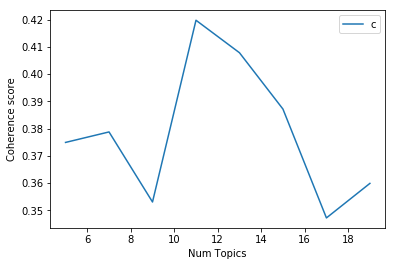

In [19]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#In this case itseems to suggest 11 topics...hmm

**Note that this function is not run with the exact correct parameters... (still need to update that)**

But if run correctly, it can be used to help us inform our choice of $t$ topics. 

Ok, so out of our list: 

1. Set up a small program that allows one to compare a new document against the existing models and corpus. 
2. Set up Dynamic Topic Modeling to track the Evolution of a Topic over time
3. Set up a Grid-Search process for fine-tuning the number of topics and other parameters
4. Include more abstracts, this time from different fields than ML, to see how well the process generalizes while mainting intra-topic distinctions

I just showed (part of) #3. Now lets look at #1: 

## Querying a new document against the existing model and corpus ##

Ideally, I will integrate this feature with a user interface, such that the user will be able to see how the words are distributed among topics, and also get a list of the most closely related documents

In [38]:
# filtered_lda.get_document_topics(dictionary.doc2bow(['general', 'topic', 'network']), per_word_topics = True)
proc_ab = prep_text(myab)

In [42]:
ab_bow = dictionary.doc2bow(bigrams[proc_ab])

In [45]:
dictionary[3706]

'gradient'

In [52]:

def colorize(ab, model, dictionary):
    """
    takes an abstract, an LDA model, and dictionary, and returns json with each word mapped to it's topic (or -1 if n/a)
    
    Still needs refinement to take advantage of bigrams
    """
    proc_ab = prep_text(ab)
#     bigram_ab = bigrams[proc_ab]
#     ab_bow = dictionary.doc2bow(bigram_ab)
    ab_bow = dictionary.doc2bow(proc_ab) # not using bigrams for now b/c it complicates things
#     print(len(ab_bow))
    doc_topics, word_topics, phi_values = model.get_document_topics(ab_bow, per_word_topics = True)
#     print(model.get_document_topics(ab_bow, per_word_topics = True))
    topic_colors = {0: 'red', 1: 'yellow', 2:'green', 3:'blue', 4:'aqua', 5: "magenta", 6:"purple"} # Have to figure out how to not hard-code this for the future
    raw_ab = ab.split()
    raw_proc = ["".join(prep_text(w)) for w in raw_ab] #this is a hack b/c the preprocessing is off
#     print("bigrams:", bigram_ab)
#     print("raw_ab: ", raw_ab)
#     print("raw_proc: ", raw_proc)
#     print("word_topics: ", word_topics)
    result = [];
    for i in range(len(raw_proc)):
#         print(raw_proc[i])
        if not raw_proc[i] or raw_proc[i] not in dictionary.token2id:
#             print("this isn't valid")
            result.append((raw_ab[i], -1))
        else:
#             print("searching for ", raw_proc[i])
            #word_topics.filter(lambda w: w[0] == dictionary.token2id[raw_proc[i]])[0] 
            sample = [w for w in word_topics if w[0] == dictionary.token2id[raw_proc[i]]]
#             print(sample)
            match = sample[0] 
#             print(match)
            result.append((raw_ab[i], match[1][0]))
#             word_topics.remove(match)
    return json.dumps(result)

myab = r"This paper presents a novel optimization method for maximizing generalization over tasks in meta-learning.\
        The goal of meta-learning is to learn a model for an agent adapting rapidly when presented with previously unseen tasks.\
        Tasks are sampled from a specific distribution which is assumed to be similar for both seen and unseen tasks. We focus on \
        a family of meta-learning methods learning initial parameters of a base model which can be fine-tuned quickly on a new task, \
        by few gradient steps (MAML). Our approach is based on pushing the parameters of the model to a direction in which tasks have\
        more agreement upon. If the gradients of a task agree with the parameters update vector, then their inner product will be a large\
        positive value. As a result, given a batch of tasks to be optimized for, we associate a positive (negative) weight to the loss\
        function of a task, if the inner product between its gradients and the average of the gradients of all tasks in the batch is a\
        positive (negative) value. Therefore, the degree of the contribution of a task to the parameter updates is controlled by introducing\
        a set of weights on the loss function of the tasks. Our method can be easily integrated with the current meta-learning algorithms for\
        neural networks. Our experiments demonstrate that it yields models with better generalization compared to MAML and Reptile."

print(colorize(myab, filtered_lda, dictionary))

# This particular choice of abstract may not have been ideal. but it gets the point across that the topics are sampled from topics 1 and 2, both of
# which have relation to the idea of gradient descent and optimization (the topic of this abstract)

[["This", -1], ["paper", -1], ["presents", 0], ["a", -1], ["novel", 0], ["optimization", 0], ["method", -1], ["for", -1], ["maximizing", 0], ["generalization", 0], ["over", -1], ["tasks", -1], ["in", -1], ["meta-learning.\\", -1], ["The", -1], ["goal", 0], ["of", -1], ["meta-learning", -1], ["is", -1], ["to", -1], ["learn", 0], ["a", -1], ["model", -1], ["for", -1], ["an", -1], ["agent", 5], ["adapting", 0], ["rapidly", 0], ["when", -1], ["presented", 0], ["with", -1], ["previously", 0], ["unseen", 0], ["tasks.\\", -1], ["Tasks", -1], ["are", -1], ["sampled", 1], ["from", -1], ["a", -1], ["specific", 0], ["distribution", -1], ["which", -1], ["is", -1], ["assumed", 0], ["to", -1], ["be", -1], ["similar", 0], ["for", -1], ["both", -1], ["seen", 0], ["and", -1], ["unseen", 0], ["tasks.", -1], ["We", -1], ["focus", 0], ["on", -1], ["\\", -1], ["a", -1], ["family", 0], ["of", -1], ["meta-learning", -1], ["methods", -1], ["learning", -1], ["initial", 0], ["parameters", -1], ["of", -1], ["a",

This function, colorize, can be called by the front end, and the Flask server can return a json with the entire text nicely labled with each word'd topic distribution. Next up is the document similarity. To do this effectivley, we need to utilize the index matrix provided by Gensim: 

In [24]:

#The index of corp_matrix so that query lookup is efficient

index = similarities.MatrixSimilarity(corp_matrix)
# index.save('./the_data_strikes_back/first_sim.index')
# index = similarities.MatrixSimilarity.load('./the_data_strikes_back/first_sim.index')

def get_similar_docs(querydoc, index, tokenizer, phraser, dictionary, top_n_docs=10): 
    """
    does a (I think?) cosine similarity with all documents in my corpus
    """
    # curr_text is a list of strings (including bigrams)
    curr_text = phraser[tokenizer(querydoc)]
    curr_bow = dictionary.doc2bow(curr_text)
    #fit the model to the bow - convert to lda space
    sims = index[curr_bow]
    return sorted(enumerate(sims), key= lambda i: -i[1])[:top_n_docs]

def display_similars(tup_array, corp_matrix, corpus= abstracts):
    result = [{"topics":model[corp_matrix[sim[0]]], "percentage": float(sim[1]), "text":corpus[sim[0]]} for sim in tup_array]
#     print(type(result[1]["topics"]), type(result[1]["percentage"]), type(result[1]["text"]))
#     sim = tup_array[0]
#     print(sim[0], type(sim[0]))
#     print(corp_matrix[sim[0]], type(corp_matrix[sim[0]]))
#     print(model[corp_matrix[sim[0]]], type(model[corp_matrix[sim[0]]]))
#     return json.dumps(result) # for some reason it won't json-serialize at the moment...hmmm
    return result

Ok, let's select a new abstract at random, and then query it against our word colorizer and our similar documents:


In [54]:
q = get_similar_docs(myab, index, prep_text, bigrams, dictionary)

display_similars(q, corp_matrix)

[{'topics': [(1, 0.07292722), (4, 0.91831183)],
  'percentage': 0.16466586291790009,
  'text': 'Support vector machines (SVMs) naturally embody sparseness due to their use of hinge loss functions. However, SVMs can not directly estimate conditional class probabilities. In this paper we propose and study a family of coherence functions, which are convex and differentiable, as surrogates of the hinge function. The coherence function is derived by using the maximum-entropy principle and is characterized by a temperature parameter. It bridges the hinge function and the logit function in logistic regression. The limit of the coherence function at zero temperature corresponds to the hinge function, and the limit of the minimizer of its expected error is the minimizer of the expected error of the hinge loss. We refer to the use of the coherence function in large-margin classification as C-learning, and we present efficient coordinate descent algorithms for the training of regularized ${\\cal 

The above are the ten most closely related docuements to our query abstract. 

### Further areas of investigation ###

1. How exactly does the similarites finder work? Would it be better if I used a TF-IDF matrix?
    - Are those really the most simlar documents? Wieht a percentage score of at most 16%? Worth investigating more criticall
    - When tested with a paper from the corpus, the function predictably returns itself as it's perfect match. 
2. Would Grid-Searching over `eta` and `alpha` and other LDA parameters result in better performing models?